In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow import keras

# For data
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [2]:
def get_cdf(x):
    """
    Computes cumulative distribution function for the input vector.
    Input—
        x: data vector
    Output—
        cdf: cumulative distribution function
    """
    n = x.size
    x_indices_sorted = np.argsort(x, kind='mergesort') # Warning: ties have different ranks.
    x_sorted = x[x_indices_sorted]
    x_sorted_cdf = np.array(list(range(n)))/(n-1)
    cdf = np.stack((x_sorted, x_sorted_cdf))
    
    return cdf

In [3]:
def map_point_to_linear_interp(x_val, memb):
    X = memb[0,:]
    Y = memb[1,:]
    i = np.sum(X < x_val) # index of first X value > x_val
    n = Y.size
    
    if(i == 0): # lower bound
        return Y[0]
    elif(i == n): # upper bound
        return Y[n - 1] 
    else: # y = b + m*x
        return (Y[i-1] + ((Y[i] - Y[i-1])/(X[i] - X[i-1]))*(x_val - X[i-1]))

def map_data_to_linear_interp(x, memb):
    """
    Map each value of vector x according to the linear function
    interpolated between the points specified by the membership function.
    Input—
        x: input vector of values
    Output—
        memb: distribution specified by two rows. Row 1 contains
            the raw x values. Row 2 contains the membership of the
            raw x values.
    """
    return np.array([map_point_to_linear_interp(x_val, memb) for x_val in x])

In [4]:
def rank_transform_fit(data):
    cdfs = list()
    for i in range(data.shape[1]):
        cdfs.append(get_cdf(data[:,i]))
    return cdfs

In [5]:
def rank_transform(data, cdfs):
    norm_data = np.zeros((data.shape[0], data.shape[1]), dtype=float)
    for i in range(data.shape[1]):
        norm_data[:,i] = map_data_to_linear_interp(data[:,i], cdfs[i])
    return norm_data

In [6]:
iris_data = load_iris()

X = iris_data.data
y = (iris_data.target==0).astype(int) # is setosa?

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
feature_names = iris_data.feature_names

In [7]:
cdfs = rank_transform_fit(X_train)
norm_X_train = rank_transform(X_train, cdfs)
norm_X_test = rank_transform(X_test, cdfs)

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
mms_X_train = scaler.transform(X_train)
mms_X_test = scaler.transform(X_test)

In [8]:
model_old = keras.models.Sequential([
    keras.layers.Input(shape=[X_train.shape[1]]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
    
model_old.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [36]:
model_old2 = keras.models.Sequential([
    keras.layers.Input(shape=[X_train.shape[1]]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
    
model_old2.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [9]:
model = keras.models.Sequential([
    keras.layers.Input(shape=[X_train.shape[1]]),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
    
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [10]:
# Define a root log directory
import os
import time

root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [11]:
run_logdir = get_run_logdir()
print(run_logdir)

./my_logs/run_2020_03_09-07_05_27


In [12]:
# Old Model learning
history = model_old.fit(X_train, y_train,
             batch_size=32, epochs=200, verbose=1,
             validation_data=(X_test, y_test),
             callbacks=[keras.callbacks.EarlyStopping(patience=10),
                       keras.callbacks.TensorBoard(run_logdir)])

Train on 112 samples, validate on 38 samples
Epoch 1/200
112/112 [==============================] - 0s 3ms/sample - loss: 0.6403 - accuracy: 0.3393 - val_loss: 0.5804 - val_accuracy: 0.8947
Epoch 2/200
112/112 [==============================] - 0s 114us/sample - loss: 0.5696 - accuracy: 0.9375 - val_loss: 0.5182 - val_accuracy: 0.9737
Epoch 3/200
112/112 [==============================] - 0s 150us/sample - loss: 0.5106 - accuracy: 1.0000 - val_loss: 0.4659 - val_accuracy: 1.0000
Epoch 4/200
112/112 [==============================] - 0s 157us/sample - loss: 0.4613 - accuracy: 1.0000 - val_loss: 0.4213 - val_accuracy: 1.0000
Epoch 5/200
112/112 [==============================] - 0s 164us/sample - loss: 0.4171 - accuracy: 1.0000 - val_loss: 0.3817 - val_accuracy: 1.0000
Epoch 6/200
112/112 [==============================] - 0s 160us/sample - loss: 0.3783 - accuracy: 1.0000 - val_loss: 0.3454 - val_accuracy: 1.0000
Epoch 7/200
112/112 [==============================] - 0s 169us/sample - lo

112/112 [==============================] - 0s 163us/sample - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0094 - val_accuracy: 1.0000
Epoch 57/200
112/112 [==============================] - 0s 162us/sample - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 58/200
112/112 [==============================] - 0s 170us/sample - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 59/200
112/112 [==============================] - 0s 168us/sample - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 60/200
112/112 [==============================] - 0s 167us/sample - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 61/200
112/112 [==============================] - 0s 182us/sample - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 62/200
112/112 [==============================] - 0s 176us/sample - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.0078 

112/112 [==============================] - 0s 164us/sample - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 112/200
112/112 [==============================] - 0s 183us/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 113/200
112/112 [==============================] - 0s 172us/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 114/200
112/112 [==============================] - 0s 168us/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 115/200
112/112 [==============================] - 0s 162us/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 116/200
112/112 [==============================] - 0s 160us/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 117/200
112/112 [==============================] - 0s 172us/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0

112/112 [==============================] - 0s 135us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 167/200
112/112 [==============================] - 0s 138us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 168/200
112/112 [==============================] - 0s 142us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 169/200
112/112 [==============================] - 0s 137us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 170/200
112/112 [==============================] - 0s 134us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 171/200
112/112 [==============================] - 0s 135us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 172/200
112/112 [==============================] - 0s 154us/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0

In [13]:
model_old.evaluate(X_test, y_test)

38/38 [==============================] - 0s 106us/sample - loss: 9.3233e-04 - accuracy: 1.0000


[0.0009323289789455501, 1.0]

In [37]:
run_logdir = get_run_logdir()
print(run_logdir)

./my_logs/run_2020_03_09-10_37_16


In [38]:
# Old Model learning -MinMaxScaler
history = model_old2.fit(mms_X_train, y_train,
             batch_size=32, epochs=200, verbose=1,
             validation_data=(mms_X_test, y_test),
             callbacks=[keras.callbacks.EarlyStopping(patience=10),
                       keras.callbacks.TensorBoard(run_logdir)])

Train on 112 samples, validate on 38 samples
Epoch 1/200
112/112 [==============================] - 0s 3ms/sample - loss: 0.6800 - accuracy: 0.6250 - val_loss: 0.6627 - val_accuracy: 0.6579
Epoch 2/200
112/112 [==============================] - 0s 111us/sample - loss: 0.6520 - accuracy: 0.6696 - val_loss: 0.6377 - val_accuracy: 0.6579
Epoch 3/200
112/112 [==============================] - 0s 134us/sample - loss: 0.6261 - accuracy: 0.6696 - val_loss: 0.6168 - val_accuracy: 0.6579
Epoch 4/200
112/112 [==============================] - 0s 126us/sample - loss: 0.6027 - accuracy: 0.6696 - val_loss: 0.5974 - val_accuracy: 0.6579
Epoch 5/200
112/112 [==============================] - 0s 141us/sample - loss: 0.5815 - accuracy: 0.6696 - val_loss: 0.5781 - val_accuracy: 0.6579
Epoch 6/200
112/112 [==============================] - 0s 132us/sample - loss: 0.5599 - accuracy: 0.6696 - val_loss: 0.5590 - val_accuracy: 0.6579
Epoch 7/200
112/112 [==============================] - 0s 144us/sample - lo

112/112 [==============================] - 0s 164us/sample - loss: 0.0257 - accuracy: 1.0000 - val_loss: 0.0210 - val_accuracy: 1.0000
Epoch 57/200
112/112 [==============================] - 0s 160us/sample - loss: 0.0243 - accuracy: 1.0000 - val_loss: 0.0197 - val_accuracy: 1.0000
Epoch 58/200
112/112 [==============================] - 0s 183us/sample - loss: 0.0231 - accuracy: 1.0000 - val_loss: 0.0186 - val_accuracy: 1.0000
Epoch 59/200
112/112 [==============================] - 0s 159us/sample - loss: 0.0218 - accuracy: 1.0000 - val_loss: 0.0175 - val_accuracy: 1.0000
Epoch 60/200
112/112 [==============================] - 0s 153us/sample - loss: 0.0206 - accuracy: 1.0000 - val_loss: 0.0164 - val_accuracy: 1.0000
Epoch 61/200
112/112 [==============================] - 0s 155us/sample - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.0154 - val_accuracy: 1.0000
Epoch 62/200
112/112 [==============================] - 0s 151us/sample - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0144 

112/112 [==============================] - 0s 134us/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 112/200
112/112 [==============================] - 0s 135us/sample - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 113/200
112/112 [==============================] - 0s 141us/sample - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 114/200
112/112 [==============================] - 0s 140us/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 115/200
112/112 [==============================] - 0s 148us/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 116/200
112/112 [==============================] - 0s 145us/sample - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 117/200
112/112 [==============================] - 0s 142us/sample - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0

Epoch 166/200
112/112 [==============================] - 0s 139us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.2155e-04 - val_accuracy: 1.0000
Epoch 167/200
112/112 [==============================] - 0s 131us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 8.1108e-04 - val_accuracy: 1.0000
Epoch 168/200
112/112 [==============================] - 0s 139us/sample - loss: 0.0012 - accuracy: 1.0000 - val_loss: 7.9875e-04 - val_accuracy: 1.0000
Epoch 169/200
112/112 [==============================] - 0s 136us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 7.8891e-04 - val_accuracy: 1.0000
Epoch 170/200
112/112 [==============================] - 0s 148us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 7.7920e-04 - val_accuracy: 1.0000
Epoch 171/200
112/112 [==============================] - 0s 146us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 7.7156e-04 - val_accuracy: 1.0000
Epoch 172/200
112/112 [==============================] - 0s 138us/sample - loss: 0

In [39]:
model_old2.evaluate(mms_X_test, y_test)

38/38 [==============================] - 0s 91us/sample - loss: 5.3354e-04 - accuracy: 1.0000


[0.0005335431702214441, 1.0]

In [14]:
run_logdir = get_run_logdir()
print(run_logdir)

./my_logs/run_2020_03_09-07_06_09


In [15]:
# New Model learning
history = model.fit(norm_X_train, y_train,
             batch_size=32, epochs=200, verbose=1,
             validation_data=(norm_X_test, y_test),
             callbacks=[keras.callbacks.EarlyStopping(patience=10),
                       keras.callbacks.TensorBoard(run_logdir)])

Train on 112 samples, validate on 38 samples
Epoch 1/200
112/112 [==============================] - 0s 3ms/sample - loss: 0.6707 - accuracy: 0.6696 - val_loss: 0.6657 - val_accuracy: 0.6579
Epoch 2/200
112/112 [==============================] - 0s 141us/sample - loss: 0.6469 - accuracy: 0.6696 - val_loss: 0.6428 - val_accuracy: 0.6579
Epoch 3/200
112/112 [==============================] - 0s 150us/sample - loss: 0.6231 - accuracy: 0.6696 - val_loss: 0.6218 - val_accuracy: 0.6579
Epoch 4/200
112/112 [==============================] - 0s 140us/sample - loss: 0.6013 - accuracy: 0.6696 - val_loss: 0.6026 - val_accuracy: 0.6579
Epoch 5/200
112/112 [==============================] - 0s 160us/sample - loss: 0.5808 - accuracy: 0.6696 - val_loss: 0.5843 - val_accuracy: 0.6579
Epoch 6/200
112/112 [==============================] - 0s 158us/sample - loss: 0.5616 - accuracy: 0.6696 - val_loss: 0.5658 - val_accuracy: 0.6579
Epoch 7/200
112/112 [==============================] - 0s 156us/sample - lo

112/112 [==============================] - 0s 169us/sample - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.0188 - val_accuracy: 1.0000
Epoch 57/200
112/112 [==============================] - 0s 173us/sample - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.0178 - val_accuracy: 1.0000
Epoch 58/200
112/112 [==============================] - 0s 177us/sample - loss: 0.0269 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 59/200
112/112 [==============================] - 0s 167us/sample - loss: 0.0258 - accuracy: 1.0000 - val_loss: 0.0159 - val_accuracy: 1.0000
Epoch 60/200
112/112 [==============================] - 0s 156us/sample - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 61/200
112/112 [==============================] - 0s 152us/sample - loss: 0.0238 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 62/200
112/112 [==============================] - 0s 152us/sample - loss: 0.0229 - accuracy: 1.0000 - val_loss: 0.0137 

112/112 [==============================] - 0s 137us/sample - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 112/200
112/112 [==============================] - 0s 147us/sample - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 113/200
112/112 [==============================] - 0s 153us/sample - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 114/200
112/112 [==============================] - 0s 149us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 115/200
112/112 [==============================] - 0s 142us/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 116/200
112/112 [==============================] - 0s 149us/sample - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 117/200
112/112 [==============================] - 0s 152us/sample - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0

Epoch 166/200
112/112 [==============================] - 0s 142us/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 7.8970e-04 - val_accuracy: 1.0000
Epoch 167/200
112/112 [==============================] - 0s 145us/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 7.7637e-04 - val_accuracy: 1.0000
Epoch 168/200
112/112 [==============================] - 0s 136us/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 7.6410e-04 - val_accuracy: 1.0000
Epoch 169/200
112/112 [==============================] - 0s 149us/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 7.5073e-04 - val_accuracy: 1.0000
Epoch 170/200
112/112 [==============================] - 0s 138us/sample - loss: 0.0023 - accuracy: 1.0000 - val_loss: 7.3688e-04 - val_accuracy: 1.0000
Epoch 171/200
112/112 [==============================] - 0s 137us/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 7.2439e-04 - val_accuracy: 1.0000
Epoch 172/200
112/112 [==============================] - 0s 136us/sample - loss: 0

In [16]:
model.evaluate(norm_X_test, y_test)

38/38 [==============================] - 0s 96us/sample - loss: 4.6775e-04 - accuracy: 1.0000


[0.0004677487472930041, 1.0]

In [17]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 61765), started 0:10:14 ago. (Use '!kill 61765' to kill it.)

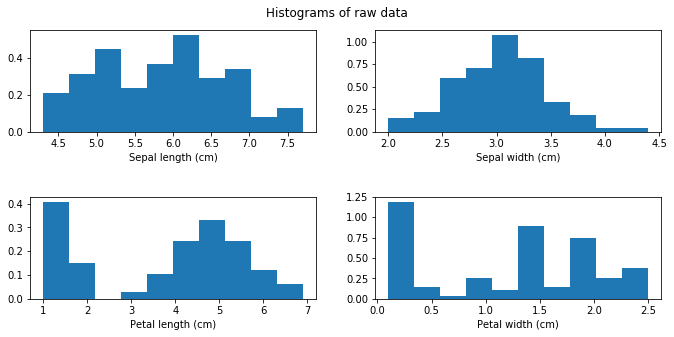

In [26]:
num_bins = 10

fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Histograms of raw data')
n, bins, patches = ax0.hist(X_train[:,0], num_bins, density=1)
ax0.set_xlabel('Sepal length (cm)')
n, bins, patches = ax1.hist(X_train[:,1], num_bins, density=1)
ax1.set_xlabel('Sepal width (cm)')
n, bins, patches = ax2.hist(X_train[:,2], num_bins, density=1)
ax2.set_xlabel('Petal length (cm)')
n, bins, patches = ax3.hist(X_train[:,3], num_bins, density=1)
ax3.set_xlabel('Petal width (cm)')
fig.tight_layout(pad=3.0)
plt.show()

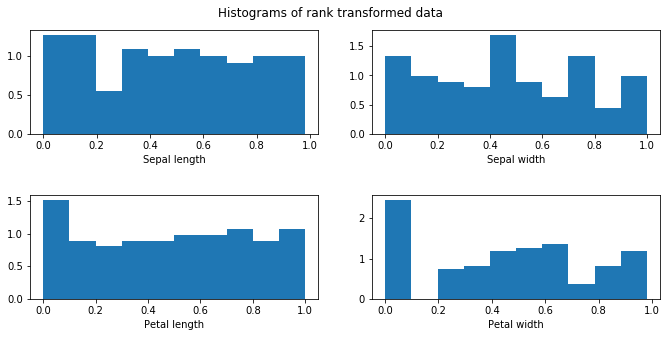

In [27]:
num_bins = 10

fig, [[ax0, ax1], [ax2, ax3]] = plt.subplots(2, 2, figsize=(10,5))
fig.suptitle('Histograms of rank transformed data')
n, bins, patches = ax0.hist(norm_X_train[:,0], num_bins, density=1)
ax0.set_xlabel('Sepal length')
n, bins, patches = ax1.hist(norm_X_train[:,1], num_bins, density=1)
ax1.set_xlabel('Sepal width')
n, bins, patches = ax2.hist(norm_X_train[:,2], num_bins, density=1)
ax2.set_xlabel('Petal length')
n, bins, patches = ax3.hist(norm_X_train[:,3], num_bins, density=1)
ax3.set_xlabel('Petal width')
fig.tight_layout(pad=3.0)
plt.show()

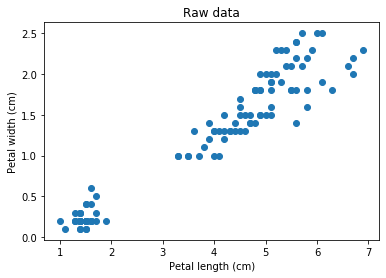

In [46]:
plt.scatter(X_train[:,2], X_train[:,3])
plt.title('Raw data')
plt.xlabel('Petal length (cm)')
plt.ylabel('Petal width (cm)')
plt.show()

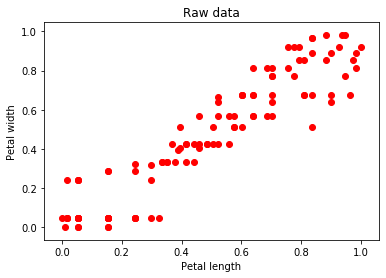

In [47]:
# Gaps because of poor handling of ties
plt.scatter(norm_X_train[:,2], norm_X_train[:,3], color='r')
plt.title('Raw data')
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.show()

In [49]:
np.sort(X_train[:,2])

array([1. , 1.1, 1.3, 1.3, 1.3, 1.3, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4, 1.4,
       1.4, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.6, 1.6, 1.6, 1.6, 1.6, 1.6, 1.7, 1.7, 1.7, 1.9, 3.3, 3.3,
       3.5, 3.5, 3.6, 3.7, 3.8, 3.9, 3.9, 4. , 4. , 4. , 4.1, 4.1, 4.2,
       4.2, 4.2, 4.3, 4.3, 4.4, 4.4, 4.5, 4.5, 4.5, 4.5, 4.6, 4.6, 4.7,
       4.7, 4.7, 4.8, 4.8, 4.8, 4.8, 4.9, 4.9, 4.9, 4.9, 4.9, 5. , 5. ,
       5.1, 5.1, 5.1, 5.1, 5.1, 5.1, 5.2, 5.2, 5.3, 5.3, 5.4, 5.4, 5.5,
       5.5, 5.5, 5.6, 5.6, 5.6, 5.6, 5.6, 5.7, 5.7, 5.8, 5.8, 5.8, 5.9,
       6. , 6.1, 6.1, 6.3, 6.6, 6.7, 6.7, 6.9])

## Computing Variable Importance using Sensitivity Analysis

### Algorithm

1. The Jacobian ($\pmb{J}$) is the partial derivative of the of the outcome variable ($y$) with respect to each rank transformed input variable ($x_i; \text{ where } i=1,\cdots, n$).

$$
\pmb{J}_{\vec{x}} = \left[\frac{\partial f(\vec{x})}{\partial x_{1}}\;\;\;\;\;\; \frac{\partial f(\vec{x})}{\partial x_{2}}\;\; \cdots\;\; \frac{\partial f(\vec{x})}{\partial x_{n}} \right]
$$

2. Compute the absolute value of the Jacobian for all the instances in the training dataset ($D^{train}$). This corresponds to the variable importance of each predictor variable according to the model induced from the training dataset.

$$
VarImp = \frac{1}{|D^{train}|}\sum_{\vec{x} \in D^{train}} |\pmb{J}_{\vec{x}}|
$$

In [20]:
def abs_jacobian_1output(x, model):
    """
    Computes the Jacobian of an input vector and 
    a Keras model with a single output node.
    
    Input—
    x: Floating numpy vector of inputs.
    model: Keras model.
    
    Output—
    jacobian: Absolute numpy Jacobian vector for 
        scalar output wrt each input.
    """
    x_tensor = tf.convert_to_tensor(x.reshape(1,-1), dtype=tf.float32)
    with tf.GradientTape() as g:
        g.watch(x_tensor)
        y_tensor = model(x_tensor)
    jacobian = g.jacobian(y_tensor, x_tensor)
    jacobian = jacobian.numpy()[0][0][0]
    
    return np.absolute(jacobian)

In [21]:
def variable_importance_sensitivity_analysis(data, model):
    """
    Computes variable importance of each input variable using sensitivity analysis.
    
    Input—
    data: Data as a numpy matrix.
    model: Keras model.
    
    Output—
    variable_importance: average absolute gradient wrt each input over all instances
    of 'data'.
    """
    abs_jacobian = np.apply_along_axis(abs_jacobian_1output,
                       1,
                       data, model=model)
    sum_jacobian = np.sum(abs_jacobian, axis=0)
    
    return sum_jacobian/data.shape[0]

In [28]:
def abs_adimensional_jacobian_1output_old(x, model):
    """
    Computes the adimensional Jacobian of an input vector and 
    a Keras model with a single output node.
    
    Input—
    x: Floating numpy vector of inputs.
    model: Keras model.
    
    Output—
    jacobian: Absolute adimensional numpy Jacobian vector for 
        scalar output wrt each input.
    """
    x_tensor = tf.convert_to_tensor(x.reshape(1,-1), dtype=tf.float32)
    with tf.GradientTape() as g:
        g.watch(x_tensor)
        y_tensor = model(x_tensor)
    jacobian = g.jacobian(y_tensor, x_tensor)
    jacobian = jacobian.numpy()[0][0][0]
    
    # Hadamard product between input-variable-gradient and 
    # variable-value/loss to remove the dimensions
    input_by_loss = x/y_tensor.numpy()[0][0]
    adim_jacobian = np.multiply(jacobian, input_by_loss)
    
    return np.absolute(adim_jacobian)

In [32]:
def variable_importance_sensitivity_analysis_old(data, model):
    """
    Computes variable importance of each input variable using sensitivity analysis.
    
    Input—
    data: Data as a numpy matrix.
    model: Keras model.
    
    Output—
    variable_importance: average absolute gradient wrt each input over all instances
    of 'data'.
    """
    abs_jacobian = np.apply_along_axis(abs_adimensional_jacobian_1output_old,
                       1,
                       data, model=model)
    sum_jacobian = np.sum(abs_jacobian, axis=0)
    
    return sum_jacobian/data.shape[0]

In [22]:
var_imp = variable_importance_sensitivity_analysis(norm_X_train, model)

In [23]:
# With rank transformation
var_imp

array([0.01562984, 0.01675144, 0.01788494, 0.01139934], dtype=float32)

In [40]:
var_imp_old = variable_importance_sensitivity_analysis_old(X_train, model_old)

In [42]:
# Raw inputs
var_imp_old

array([1.41839205, 1.5823931 , 3.79978242, 0.77141107])

In [41]:
var_imp_old2 = variable_importance_sensitivity_analysis_old(mms_X_train, model_old)

In [43]:
# With min-max scaling
var_imp_old2

array([0.10686272, 0.14056886, 0.41952085, 0.19803721])

In [44]:
temp = variable_importance_sensitivity_analysis_old(norm_X_train, model)

In [45]:
# multiplying with odds ratio
temp

array([2.55622709, 1.01347387, 3.21254169, 1.96554852])